# HW3: Variational Autoencoders
**Meng Linghui**  

mengreinhold@163.com

## 1 VAE in 2D
### Part A

In this problem, you will investigate when a VAE places information into its latent code. Run this snippet generate two datasets: 

In [36]:
import numpy as np
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


**Train one VAE in this configuration on both datasets:**  
• 2D latent variables z with a standard normal prior $p(z) = N(z;0,I)$.   
• An approximate posterior $q_\theta(z|x) = N(z;\mu_\theta(x),\sigma_\theta(x))$, where $\mu_\theta(x)$ is a mean vector and $\sigma_\theta(x)$ and is a diagonal covariance matrix   
• A decoder $p_\theta(x|z) = N(x;\mu_\theta(z),\sigma_\theta(z))$, where $\mu_\theta(z)$ is a mean vector and $\sigma_\theta(z)$ and is a diagonal covariance matrix 

### show the sample data

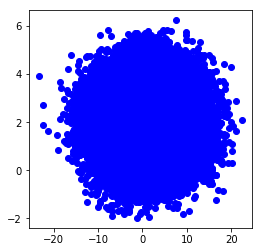

In [35]:
import matplotlib.pyplot as plt
x = sample_data_1()
plt.figure(figsize=(4,4))
plt.plot(x[:,0],x[:,1],'bo')
plt.show()

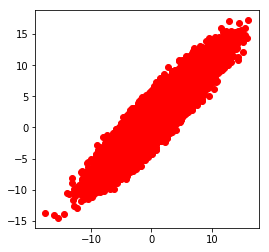

In [87]:
y = sample_data_2()
plt.figure(figsize=(4,4))
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()

In [14]:
def sample_from_q_theta_z_x(x): # encoder
    mu = np.mean(x, axis=0)
    sigma = np.cov(x, rowvar=False)
    z = np.random.normal(mu, sigma, 100000)
    return z
def sample_from_p_theta_x_z(z): # decoder
    mu = np.mean(z, axis=0)
    sigma = np.cov(z, rowvar=False)
    x = np.random.normal(mu, sigma, 100000)
    return x

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
x = sample_data_1()
# z = np.random.multivariate_normal([0,0], [[1, 1],[1, 1]], 100000)
# x = np.hstack((x, z))
x = torch.from_numpy(x)
training_set = x[:int(len(x)*0.6)] 
val_set = x[int(len(x)*0.6):int(len(x)*0.8)]
test_set = x[int(len(x)*0.8):]

### Hyper-param

In [52]:
batch_size = 20
epochs = 30

In [83]:
class SimpleVAE(nn.Module):
    def __init__(self, var_dim):
        super(SimpleVAE, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=32)
        self.enc_mean = nn.Linear(in_features=32, out_features=8)
        self.enc_logvar = nn.Linear(in_features=32, out_features=var_dim)
        self.dec1 = nn.Linear(in_features=8, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=2)
        self.mse = nn.MSELoss()
        
    def encoder(self, x):
        x = x.type(torch.FloatTensor)
        h1 = F.relu(self.fc1(x))
        return self.enc_mean(h1), self.enc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decoder(self, x):
        h2 = F.relu(self.dec1(x))
        return self.dec2(h2)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def loss_function(self, true_x):
        batch_size = len(true_x)
        x, mu, logvar = self.forward(true_x)
        x = x.type(torch.DoubleTensor)
        
        if self.training:
            MSE = 0
            for datapoint in true_x:
                MSE += self.mse(datapoint, x)
            MSE = MSE / len(true_x)
        else:
            MSE = self.mse(true_x, x)
        
        KLD = -0.5*torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
        KLD /= (batch_size * 2)
        
        return MSE + KLD

In [84]:
net = SimpleVAE(1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([32, 2])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([8, 32])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> torch.Size([1, 32])
<class 'torch.Tensor'> torch.Size([1])
<class 'torch.Tensor'> torch.Size([32, 8])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([2, 32])
<class 'torch.Tensor'> torch.Size([2])


In [88]:
import warnings

warnings.filterwarnings('ignore')

Epoch 0: loss 13.22603953842621 val_loss 10.208075580809155 
Epoch 10: loss 16.98896396998736 val_loss 14.249209144124393 
Epoch 20: loss 11.654572771110406 val_loss 16.559673371136988 


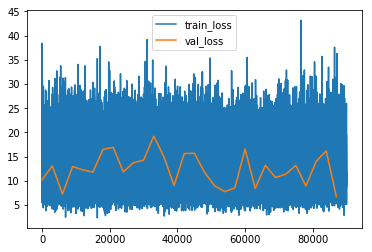

In [89]:
train_iter = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
val_set_iter = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    
    for train_batch in train_iter:
        loss = net.loss_function(train_batch)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_set_iter))
        val_loss = net.loss_function(val_batch)
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))
        
import matplotlib.pyplot as plt
plt.plot(losses, label='train_loss')
plt.plot(np.arange(0, len(losses), int(len(losses)/len(val_losses))), val_losses, label='val_loss')
plt.legend()
plt.show()